[ 755.86068293 -527.63293702  -30.7681685   585.02481004    0.        ]


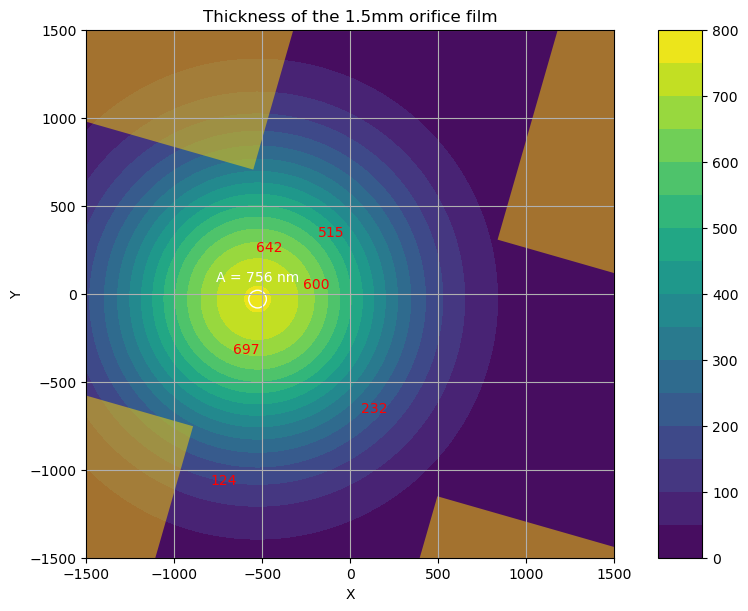

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.patches import Rectangle, Circle

def radial_gaussian(params, x, y):
    A, x0, y0, sigma, C = params
    return (A * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))) + C


# Define the cost function: mean squared error between the data and the Gaussian
def cost_function(params, x, y, values):
    return np.mean((values - radial_gaussian(params, x, y))**2)

# Sample data
x_coords = np.array([-194, -462, -107, -719, 134, -594])
y_coords = np.array([55, 263, 348, -1059, -649, -315])
thickness = np.array([600, 642, 515, 124, 232, 697])

# Initial guess [A, x0, y0, sigma, C]
init_params = [np.max(thickness), np.mean(x_coords), np.mean(y_coords), 150, 80]


x_min = -1500
y_min = -1500
x_max = 1500
y_max = 1500

# electrodes
rectangles = [
    [(-552, 705), -2000, 2000],
    [(836, 307), 2000, 2000],
    [(-894, -753),-2000, -2000],
    [(494, -1151), 2000, -2000]
]

# Compute rotation angle in degrees
dy = 307 - 705
dx = 836 - (-552)
theta = np.arctan2(dy, dx) * (180/np.pi)

# Optimize
#result = minimize(cost_function, init_params, args=(x_coords, y_coords, thickness))
result = minimize(cost_function, init_params, args=(x_coords, y_coords, thickness), method='L-BFGS-B', bounds=[(0, None), (None, None), (None, None), (0, None), (0, 100)])
best_fit_params = result.x

cmap='viridis'
contour_count = 15

print(best_fit_params)

# Create a grid for visualization
x = np.linspace(x_min, x_max, 400)
y = np.linspace(y_min, y_max, 400)

X, Y = np.meshgrid(x, y)

Z = radial_gaussian(best_fit_params, X, Y)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# Plotting the fitted Gaussian as a semitransparent area
ax.contourf(X, Y, Z, contour_count, cmap=cmap, alpha=0.6)

# Plotting the original data points
ax.scatter(x_coords, y_coords, s=thickness, c='red', edgecolors='black')

for rect in rectangles:
    corner, width, height = rect
    ax.add_patch(Rectangle(corner, width, height, facecolor='gold', alpha=0.5, angle=theta))
    ax.scatter(*corner, color='black', marker='x', s=100)

# Adding a circle at the Gaussian's center and annotating with the amplitude
A, x0, y0, r0, sigma = best_fit_params
circle_radius = 50  # adjust as needed
ax.add_patch(Circle((x0, y0), circle_radius, fill=False, edgecolor='white'))
ax.annotate(f"A = {A:.0f} nm", (x0, y0 + circle_radius + 50), color='white', ha='center')

[ax.annotate(str(t), (x,y), color='red', ha='center', va='center') for x, y, t in zip(x_coords, y_coords, thickness)]

    
ax.set_title("Thickness of the 1.5mm orifice film")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Setting the x and y axis limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.grid(True)
ax.set_aspect('equal')

plt.colorbar(ax.contourf(X, Y, Z, contour_count , cmap=cmap, alpha=0.6))
plt.show()

# Save the figure
filename = ax.get_title().replace(' ', '_') + ".png"
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
plt.close(fig)